### 1. Instructions
Congratulations on making it to the MLE challenge step of the hiring process! We are as excited as you are to consider you for a MLE role on our team!

#### 1.1. Problem Description
In this challenge, you are tasked with scaling up the model training pipeline developed by a Data Scientist team member. This notebook shares the solution they have developed for the [M5 competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy) posted on Kaggle. Please note that the objective of this challenge is totally different than that of the Kaggle competition. To reduce computational requirements, we have decreased the number of time series from 30,490 (in the Kaggle dataset) to 1,390. Also, since the objective of this challenge is not to produce best model metrics, but to test the scalability of your pipeline, we strongly suggest you to use just 50 epochs for model training.

#### 1.2. Files Description
Please make sure the folder you received follows the below structure or as shown in <code>Folder Structure.png</code>. In case of discrepancies, please reach out to your recruiter. Before proceeding further in this notebook, read through the <code>Data and Model Description</code> document and files in <code>data</code> folder for an understanding of the data specific to this challenge.</br>
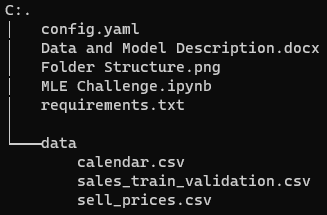

#### 1.3. Notebook Description
This notebook has the following sections:
<ol>
    <li>Instructions,</li>
    <li>Import Libraries,</li>
    <li>User Defined Functions - helper functions with decent documentation. Since these are designed to be used as black-box, docstrings have not been provided. Please refer to usage examples in the notebook and your own debugging techniques to address any issues. <code>Table 1</code> in <code>Data and Model Description</code> document has been implemented in the <code>get_model_details_per_level</code> UDF and example usage has been shown in <code>cell 13</code> of this notebook,</li>
    <li>Read Data,</li>
    <li>Data Exploration - minimal data exploration to give you a feel for the data. Feel free to further explore data on your own as needed,</li>
    <li>Data Preparation,</li>
    <li>Training Deep Learning Model - train single CNN+LSTM model using data for all time series, ie, at model level 1.</li>
</ol>
After creating your environment with the libraries listed in Section 2 or by using the attached <code>requirements.txt</code> file, please make sure you can run all cells without any errors. The notebook has been tested to run with these libraries, so in case of errors, please give a good try to debug. As a last resort, you may reach out to your recruiter.

#### 1.4. Objectives
Following are your tasks:
<ol>
    <li>Package below model training code into python files. The entry point is main.py. Then calling ‘Python main.py’ runs model training based on the aggregation level specified in <code>config.yaml</code>. For example, if <code>model_level=10</code> in the config, there will be 139 models based on the <code>Data and Model Description</code> document - one for each item. Training data for each model will be the raw time series contributing to that level. So, in this example, model for item <code>HOBBIES_1_001</code> will be trained using 10 time series corresponding to its sales in the 10 stores.</li>
    <li>Scale up the model training pipeline to run in parallel utilizing multiple cores on a computer.</li>
    <li><b>[Extra Credit]</b> You are encouraged to reorganize the code to ease pipeline definition. In the ML context, pipeline means a list of steps applied to the input data sequentially and output the model at the last step. Please refer to <a href="https://towardsdatascience.com/a-brief-introduction-to-scikit-pipelines-888edc86da9b">A Brief Introduction to SciKit Pipelines</a> for an introduction.</li>
    <li><b>[Extra Credit]</b> Deploy the model locally using a web application (like Streamlit or Dash) and develop a front-end web interface to plot model predictions for different time series at the specified model level using dropdowns. There will be two dropdowns - first to select the model and second to select the timeseries. In the above example, first dropdown will allow the user to load the model for <code>HOBBIES_1_001</code> item (could be any of the 139 items) and the second will allow them to load predictions for this item at <code>CA_1</code> store (could be any of the 10 stores).</li>
</ol>

### 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import calendar

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, BatchNormalization, Dense
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

import warnings

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)

tf.random.set_seed(51)
np.random.seed(51)

### 3. User Defined Functions

In [2]:
# For a given level of model, get the number of models that need to be trained and the number of time series for training each model
def get_model_details_per_level(sales_df, groupbys, level):
    if isinstance(groupbys[level-1], list):
        list_groupby = groupbys[level-1]
    else:
        list_groupby = [groupbys[level-1]]
    return sales_df.groupby(list_groupby).count().reset_index()[list_groupby+['id']].rename(columns={'id':'number of raw time series for training each model at level '+str(level)})

In [3]:
# Downcast numeric columns to save memory
def downcast_dtypes(df):
  start_mem = df.memory_usage().sum() / 1024**2
  cols_float = df.select_dtypes('float').columns
  cols_int = df.select_dtypes('integer').columns
  df[cols_float] = df[cols_float].apply(pd.to_numeric, downcast='float')
  df[cols_int] = df[cols_int].apply(pd.to_numeric, downcast='integer')
  if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
  end_mem = df.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [4]:
# Create plots to visualize validation and prediction data from a model with an option to plot the training data as well
def plot_preds(train_df, valid_df, pred_df, calendar_df, plot_train_data=False):

  n_ts = len(train_df)
  if n_ts > 10:                 # limiting the number of timeseries that can be plotted to reduce plotly runtime
    n_ts = 10
    train_df  = train_df.iloc[:10,:]
    print('Since there are more than 10 timeseries, plotting only top 10 as an example')
  
  fig = make_subplots(rows=n_ts, cols=1, subplot_titles=[id.replace('_validation','') for id in train_df['id']])

  for i in range(n_ts):

    train_ts_df = train_df[[col for col in train_df.columns if 'd_' in col]].iloc[i].reset_index().rename(columns={'index':'d'})
    valid_ts_df = valid_df[[col for col in valid_df.columns if 'd_' in col]].iloc[i].reset_index().rename(columns={'index':'d'})
    pred_ts_df  = pred_df [[col for col in pred_df.columns  if 'd_' in col]].iloc[i].reset_index().rename(columns={'index':'d'})

    train_ts_df = pd.merge(train_ts_df, calendar_df[['d','date']])
    valid_ts_df = pd.merge(valid_ts_df, calendar_df[['d','date']])
    pred_ts_df  = pd.merge(pred_ts_df, calendar_df[['d','date']])

    showlegend=True if i==0 else False

    if plot_train_data:
      fig.add_trace(go.Scatter(x=train_ts_df['date'], y=train_ts_df.iloc[:,1], name='training', line=dict(color='blue'),  showlegend=True if i==0 else False, legendgroup=str(i)), row=i+1, col=1)
    fig.add_trace(go.Scatter(x=valid_ts_df['date'], y=valid_ts_df.iloc[:,1], name='validation', line=dict(color='black'), showlegend=True if i==0 else False, legendgroup=str(i)), row=i+1, col=1)
    fig.add_trace(go.Scatter(x=pred_ts_df['date'],  y=pred_ts_df.iloc[:,1], name='predictions', line=dict(color='green'), showlegend=True if i==0 else False, legendgroup=str(i)), row=i+1, col=1)
  
  fig.update_layout(height=n_ts*180, margin=dict(l=0,r=0,b=0,t=20), legend_tracegroupgap=150)
  fig.show()

In [5]:
# Create input and output slices for NN model
def get_input_output_slices_exo(data_array, input_slice_start_min, input_slice_start_max, n_training, n_products_stores):
    
    X = []
    y = []
    
    print('Sample input and output slices for 1 step prediction')
    for i in range(input_slice_start_min, input_slice_start_max):
        if i<=input_slice_start_min+2 or i>input_slice_start_max-4:            # print a few slices at the start and end for debugging
            print('Input:',range(i,i+n_training),',  Output:',i+n_training)
        X.append(data_array[i:i+n_training])
        y.append(data_array[i+n_training,:n_products_stores])
    
    return X, y

In [6]:
# Create baseline NN model using CNN-LSTM architecture that makes one step ahead predictions
def build_baseline_model():
    
    baseline_model = Sequential()

    conv1_filters = 64
    baseline_model.add(Conv1D(name='conv1', kernel_size=7, strides=1, padding="causal", activation="relu", filters=conv1_filters, input_shape=(n_training, n_products_stores_exo)))
    baseline_model.add(MaxPooling1D(name='pool1'))

    baseline_model.add(Conv1D(name='conv2', kernel_size=7, strides=1, padding="causal", activation='relu', filters=int(baseline_model.get_layer('conv1').output.shape[2]/2)))
    baseline_model.add(MaxPooling1D(name='pool2'))

    lstm1_units = 256
    baseline_model.add(LSTM(name='lstm1', units=lstm1_units, return_sequences=True))
    baseline_model.add(BatchNormalization(name='norm1'))

    baseline_model.add(LSTM(name='lstm2', units=int(baseline_model.get_layer('lstm1').output.shape[2]/2), return_sequences=True))
    baseline_model.add(BatchNormalization(name='norm2'))

    baseline_model.add(LSTM(name='lstm3', units=int(baseline_model.get_layer('lstm2').output.shape[2]/2)))
    baseline_model.add(BatchNormalization(name='norm3'))

    baseline_model.add(Dense(name='dense', units=n_outputs))

    learning_rate = 0.001
    opt_adam = Adam(clipvalue=0.5, learning_rate=learning_rate)

    baseline_model.compile(loss='mse', optimizer=opt_adam, metrics=[RootMeanSquaredError()])
    
    return baseline_model

In [7]:
# Compute WRMSSE for NN models
def evaluate_model(model, X_valid):
    
    y_valid_pred=[]
    for X in X_valid:
        y_valid_pred_day = model.predict(X.reshape(1,n_training,n_products_stores_exo))
        y_valid_pred_day = sc.inverse_transform(y_valid_pred_day)
        y_valid_pred.append(y_valid_pred_day)
        
    y_valid_pred_df = pd.DataFrame(np.array([y_valid_pred[i].reshape(-1,) for i in range(len(y_valid_pred))]).T, columns=valid_d_cols)
    if not all([col in y_valid_pred_df.columns for col in fixed_cols]):
      y_valid_pred_df = pd.concat([train_df[fixed_cols],y_valid_pred_df],axis=1,sort=False)
    
    return y_valid_pred_df

### 4. Read Data

In [8]:
calendar_df = pd.read_csv('./data/calendar.csv')
sales_df = pd.read_csv('./data/sales_train_validation.csv')
prices_df = pd.read_csv('./data/sell_prices.csv')

In [9]:
calendar_df.shape, calendar_df.head(3)

((1969, 14),
          date  wm_yr_wk   weekday  wday  month  year    d event_name_1  \
 0  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
 1  2011-01-30     11101    Sunday     2      1  2011  d_2          NaN   
 2  2011-01-31     11101    Monday     3      1  2011  d_3          NaN   
 
   event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
 0          NaN          NaN          NaN        0        0        0  
 1          NaN          NaN          NaN        0        0        0  
 2          NaN          NaN          NaN        0        0        0  )

In [10]:
sales_df.shape, sales_df.head(3)

((1390, 1919),
                               id        item_id    dept_id   cat_id store_id  \
 0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
 1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
 2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
 
   state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
 0       CA    0    0    0    0  ...       1       3       0       1       1   
 1       CA    0    0    0    0  ...       0       0       0       0       0   
 2       CA    0    0    0    0  ...       2       1       2       1       1   
 
    d_1909  d_1910  d_1911  d_1912  d_1913  
 0       1       3       0       1       1  
 1       1       0       0       0       0  
 2       1       0       1       1       1  
 
 [3 rows x 1919 columns])

In [11]:
prices_df.shape, prices_df.head(3)

((6841121, 4),
   store_id        item_id  wm_yr_wk  sell_price
 0     CA_1  HOBBIES_1_001     11325        9.58
 1     CA_1  HOBBIES_1_001     11326        9.58
 2     CA_1  HOBBIES_1_001     11327        8.26)

In [12]:
calendar_df = downcast_dtypes(calendar_df)
sales_df = downcast_dtypes(sales_df)
prices_df = downcast_dtypes(prices_df)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to  2.66 Mb (86.9% reduction)
Mem. usage decreased to 143.53 Mb (31.2% reduction)


In [38]:
groupbys = ('for_all', 'state_id', 'store_id', 'cat_id', 'dept_id',['state_id', 'cat_id'],  
            ['state_id', 'dept_id'], ['store_id', 'cat_id'],['store_id', 'dept_id'], 'item_id', 
            ['item_id', 'state_id'], ['item_id', 'store_id'])
model_level = 10

get_model_details_per_level(sales_df, groupbys, level)

state_id      dept_id  \
0        CA      FOODS_1   
1        CA      FOODS_2   
2        CA      FOODS_3   
3        CA    HOBBIES_1   
4        CA    HOBBIES_2   
5        CA  HOUSEHOLD_1   
6        CA  HOUSEHOLD_2   
7        TX      FOODS_1   
8        TX      FOODS_2   
9        TX      FOODS_3   
10       TX    HOBBIES_1   
11       TX    HOBBIES_2   
12       TX  HOUSEHOLD_1   
13       TX  HOUSEHOLD_2   
14       WI      FOODS_1   
15       WI      FOODS_2   
16       WI      FOODS_3   
17       WI    HOBBIES_1   
18       WI    HOBBIES_2   
19       WI  HOUSEHOLD_1   
20       WI  HOUSEHOLD_2   

    number of raw time series for training each model at level 7  
0                                                  76             
1                                                  80             
2                                                  80             
3                                                  80             
4                                                  80             
5                                                  80             
6                                                  80             
7                                                  57             
8                                                  60             
9                                                  60             
10                                                 60             
11                                                 60             
12                                                 60             
13                                                 60             
14                                                 57             
15                                                 60             
16                                                 60             
17                                                 60             
18                                                 60             
19                                                 60             
20                                                 60

### 5. Data Exploration

#### 5.1. Overall sales pattern

In [14]:
sales_df['for_all'] = "all"             # for aggregating all time series
agg_sales_df = pd.merge(sales_df.groupby('for_all').sum().T.reset_index().rename(columns={'index':'d','all':'agg_sales'}), calendar_df[['d','date','weekday','month']])
sales_df = sales_df.drop(columns=['for_all'])

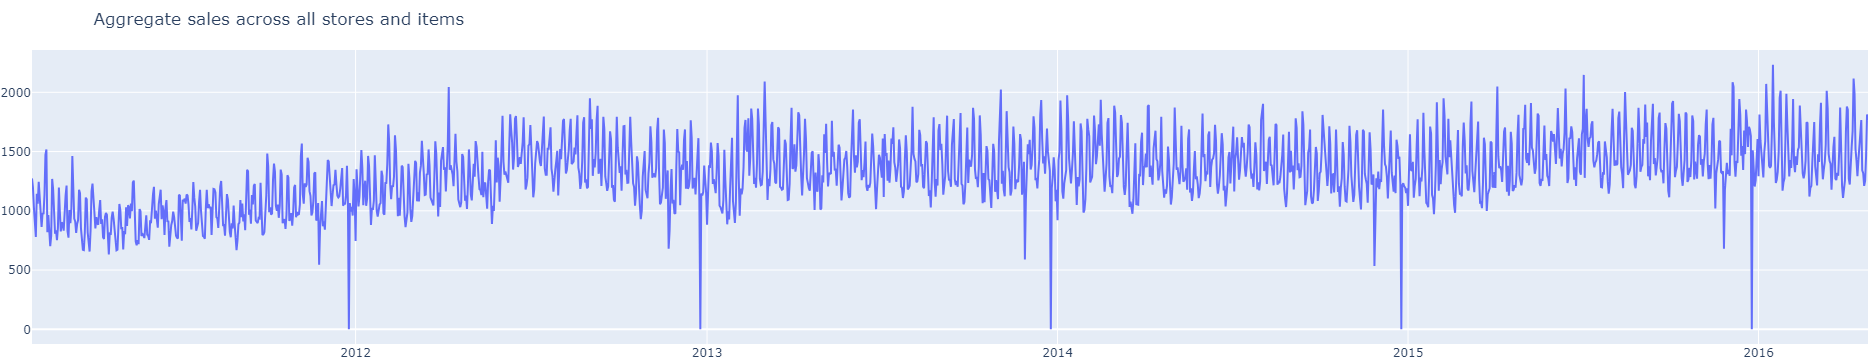

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=agg_sales_df['date'], y=agg_sales_df['agg_sales'], hovertemplate="Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Agg Sales: %{y:%d}"))
fig.update_layout(title='Aggregate sales across all stores and items', margin=dict(l=0,r=0,b=0,t=50))

Aggregated sales across all stores and items has a varying upward trend and a weekly seasonality with high sales during weekends and low sales during weekdays.

#### 5.2. Sales pattern across each state

In [16]:
sales_melt_df = pd.melt(sales_df, id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],var_name='d',value_name='sales')
sales_melt_df = pd.merge(sales_melt_df, calendar_df[['d','date']])
sales_by_state_df = sales_melt_df.groupby(['state_id','date']).sum().reset_index()
sales_CA_df = sales_by_state_df[sales_by_state_df['state_id']=='CA']
sales_TX_df = sales_by_state_df[sales_by_state_df['state_id']=='TX']
sales_WI_df = sales_by_state_df[sales_by_state_df['state_id']=='WI']

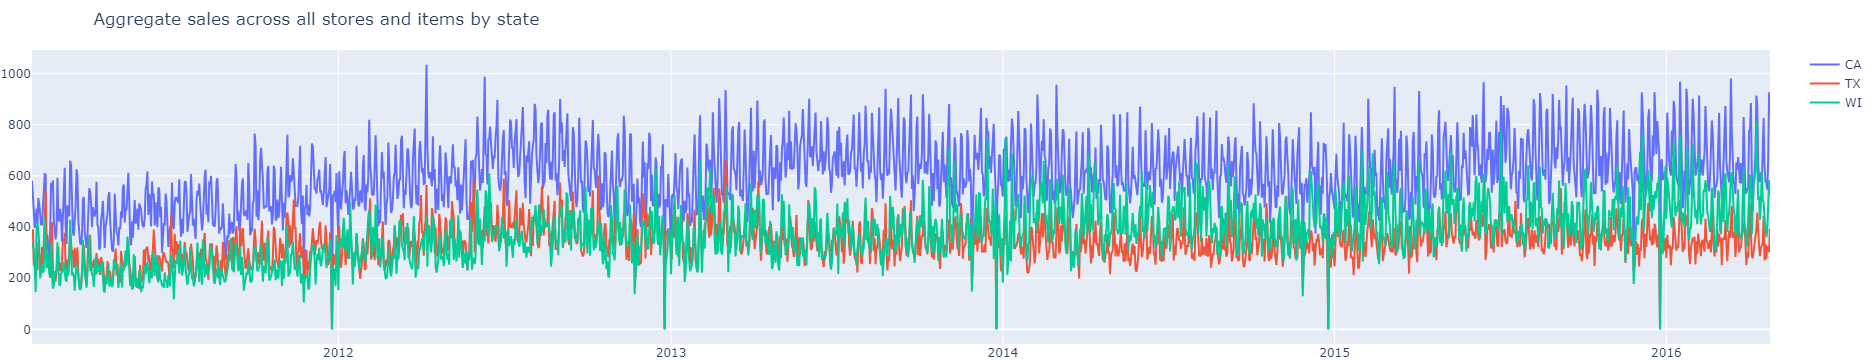

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_CA_df['date'], y=sales_CA_df['sales'], name='CA', hovertemplate="Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Agg Sales: %{y:%d}"))
fig.add_trace(go.Scatter(x=sales_TX_df['date'], y=sales_TX_df['sales'], name='TX', hovertemplate="Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Agg Sales: %{y:%d}"))
fig.add_trace(go.Scatter(x=sales_WI_df['date'], y=sales_WI_df['sales'], name='WI', hovertemplate="Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Agg Sales: %{y:%d}"))
fig.update_layout(title='Aggregate sales across all stores and items by state', margin=dict(l=0,r=0,b=0,t=50))

The trend and seasonality seen above hold across the three states.

#### 5.3. Sales patterns across each category

In [18]:
sales_by_cat_df = sales_melt_df.groupby(['cat_id','date']).sum().reset_index()
sales_FOODS_df = sales_by_cat_df[sales_by_cat_df['cat_id']=='FOODS']
sales_HOBBIES_df = sales_by_cat_df[sales_by_cat_df['cat_id']=='HOBBIES']
sales_HOUSEHOLD_df = sales_by_cat_df[sales_by_cat_df['cat_id']=='HOUSEHOLD']

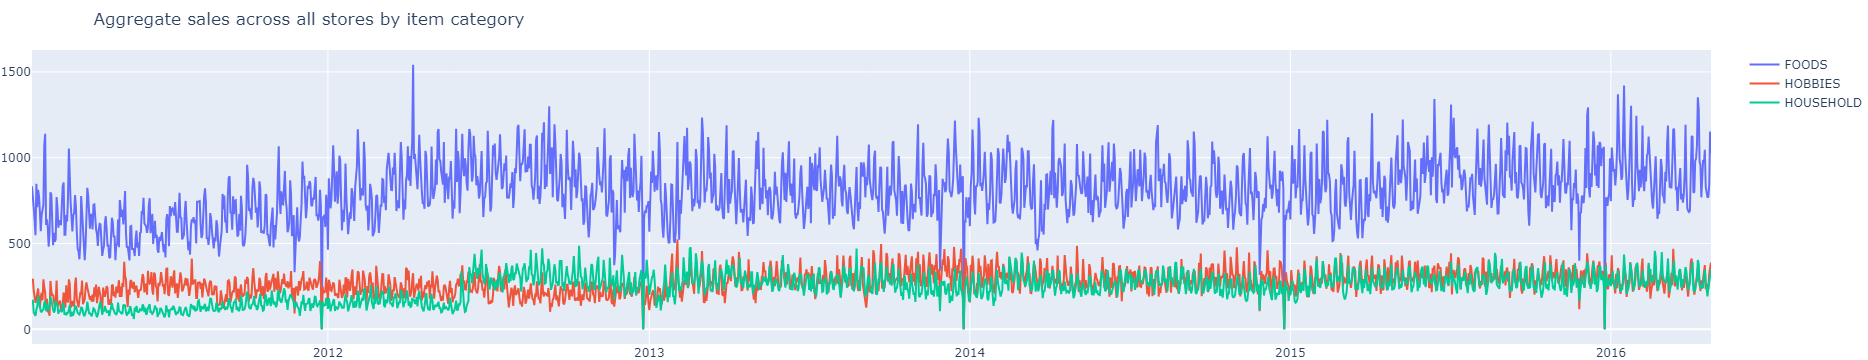

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales_FOODS_df['date'], y=sales_FOODS_df['sales'], name='FOODS', hovertemplate="Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Agg Sales: %{y:%d}"))
fig.add_trace(go.Scatter(x=sales_HOBBIES_df['date'], y=sales_HOBBIES_df['sales'], name='HOBBIES', hovertemplate="Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Agg Sales: %{y:%d}"))
fig.add_trace(go.Scatter(x=sales_HOUSEHOLD_df['date'], y=sales_HOUSEHOLD_df['sales'], name='HOUSEHOLD', hovertemplate="Date: %{x|%Y-%m-%d}<br>Day: %{x|%A}<br>Agg Sales: %{y:%d}"))
fig.update_layout(title='Aggregate sales across all stores by item category', margin=dict(l=0,r=0,b=0,t=50))

The trend and seasonality observed on overall aggregated data hold across the three item categories.

#### 5.4. Average monthly sales

In [20]:
agg_sales_df['month'] = pd.to_datetime(agg_sales_df['date']).dt.month
monthly_avg_sales_df = agg_sales_df[['month','agg_sales']].groupby('month').mean().reset_index()
monthly_avg_sales_df['month_name'] = monthly_avg_sales_df['month'].apply(lambda x: calendar.month_abbr[x])

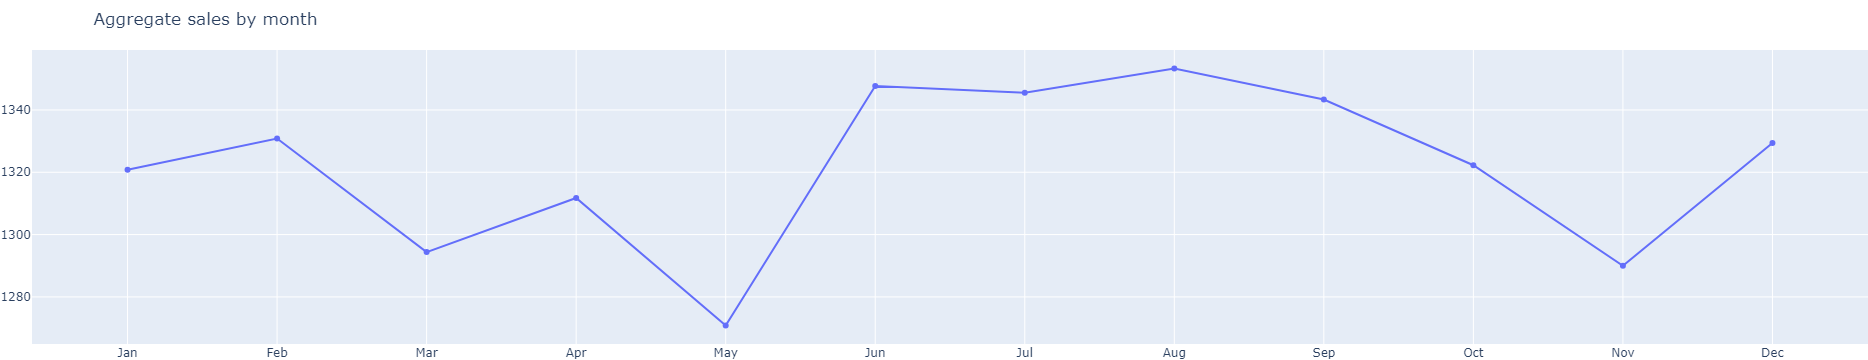

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_avg_sales_df['month_name'], y=monthly_avg_sales_df['agg_sales']))
fig.update_layout(title='Aggregate sales by month', margin=dict(l=0,r=0,b=0,t=50))

Spring peak occurs in Feb and Fall peak in August with the Fall peak being considerably higher.

#### 5.5. Average weekly sales

In [22]:
weekday_agg_sales_df = agg_sales_df[['weekday','agg_sales']].groupby('weekday').sum().reset_index()
weekday_agg_sales_df = pd.merge(weekday_agg_sales_df, calendar_df[['weekday','wday']].drop_duplicates()).sort_values(by=['wday'])

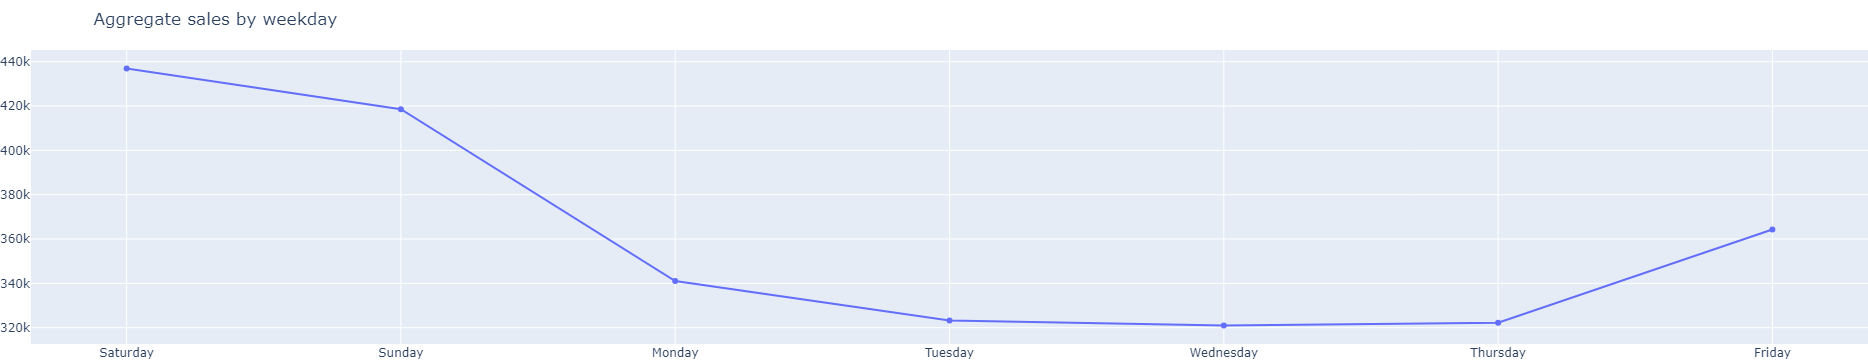

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=weekday_agg_sales_df['weekday'], y=weekday_agg_sales_df['agg_sales']))
fig.update_layout(title='Aggregate sales by weekday', margin=dict(l=0,r=0,b=0,t=50))

Sales are high during weekends and low during weekdays.

### 6. Data Preparation

#### 6.1. Split into Train and Validation Slices

In [24]:
n_training = 28   # training horizon: number of days of past sales for making predictions
n_forecast = 28   # forecast horizon: number of days of future sales to predict

train_df = sales_df.iloc[:,:-n_forecast].copy()
valid_df = sales_df.iloc[:,-n_forecast:].copy()

train_d_cols = [col for col in train_df.columns if col.startswith('d_')]
fixed_cols = [col for col in train_df.columns if not col.startswith('d_')]
valid_d_cols = [col for col in valid_df.columns if col.startswith('d_')]

if not all([col in valid_df.columns for col in fixed_cols]):
    valid_df = pd.concat([train_df[fixed_cols],valid_df],axis=1,sort=False)

In [25]:
# transposing data to merge exogenous features from calendar_df
sales_t_df = sales_df[[col for col in sales_df.columns if col not in ['id','item_id','dept_id','cat_id','store_id','state_id']]].T.reset_index().rename(columns={'index':'d'})
n_products_stores = sales_t_df[[col for col in sales_t_df.columns if 'd' not in str(col)]].shape[1]

calendar_df['event_1_flag'] = calendar_df['event_name_1'].notna().astype(int)
calendar_df['event_2_flag'] = calendar_df['event_name_2'].notna().astype(int)
sales_t_exo_df = pd.merge(sales_t_df, calendar_df[['d','snap_CA','snap_TX','snap_WI','event_1_flag','event_2_flag']]).drop(columns=['d'])        # merging exogenous features to timeseries sales data
sales_t_df = sales_t_df.drop(columns=['d'])
n_products_stores_exo = sales_t_exo_df[[col for col in sales_t_exo_df.columns if 'd' not in str(col)]].shape[1]

In [26]:
# split sales data into train and validation
train_sales_t_df = sales_t_df.iloc[:-n_forecast,:]
valid_sales_t_df = sales_t_df.iloc[-n_forecast:,:]

# split sales data merged with exogenous features into train and validation
train_sales_t_exo_df = sales_t_exo_df.iloc[:-n_forecast,:]
valid_sales_t_exo_df = sales_t_exo_df.iloc[-n_forecast:,:]

#### 6.2. Scaling and Preparing Train and Validation Slices

In [27]:
# Feature Scaling: Scale features using min-max scaler in range 0-1

# scaling train/validation data without exogenous features
sc = MinMaxScaler(feature_range = (0, 1))
train_sales_t_df.columns = train_sales_t_df.columns.astype(str)
valid_sales_t_df.columns  = valid_sales_t_df.columns.astype(str)
train_sales_t_df_scaled = sc.fit_transform(train_sales_t_df)
valid_sales_t_df_scaled  = sc.transform(valid_sales_t_df)

# scaling train/validation data with exogenous features
sc_exo = MinMaxScaler(feature_range = (0, 1))
train_sales_t_exo_df.columns = train_sales_t_exo_df.columns.astype(str)
valid_sales_t_exo_df.columns  = valid_sales_t_exo_df.columns.astype(str)
train_sales_t_exo_df_scaled = sc_exo.fit_transform(train_sales_t_exo_df)
valid_sales_t_exo_df_scaled  = sc_exo.transform(valid_sales_t_exo_df)

In [28]:
# Prepare training data slices
print('\nTraining data preparation:')
X_train_exo, y_train_exo = get_input_output_slices_exo(train_sales_t_exo_df_scaled, 0, train_sales_t_exo_df_scaled.shape[0]-n_training, n_training, n_products_stores)

# Prepare validataion data slices
print('\nValidation data preparation:')
concat_train_valid_exo_scaled = np.concatenate((train_sales_t_exo_df_scaled, valid_sales_t_exo_df_scaled), axis=0)
X_valid_exo,  y_valid_exo  = get_input_output_slices_exo(concat_train_valid_exo_scaled, concat_train_valid_exo_scaled.shape[0]-n_training-n_forecast, concat_train_valid_exo_scaled.shape[0]-n_forecast, n_training, n_products_stores)

# Convert training and validation data slices to numpy arrays since providing them as a list to tensorflow throws an error
X_train_exo = np.array(X_train_exo)
y_train_exo = np.array(y_train_exo)
X_valid_exo  = np.array(X_valid_exo)
y_valid_exo  = np.array(y_valid_exo)


Training data preparation:
Sample input and output slices for 1 step prediction
Input: range(0, 28) ,  Output: 28
Input: range(1, 29) ,  Output: 29
Input: range(2, 30) ,  Output: 30
Input: range(1854, 1882) ,  Output: 1882
Input: range(1855, 1883) ,  Output: 1883
Input: range(1856, 1884) ,  Output: 1884

Validation data preparation:
Sample input and output slices for 1 step prediction
Input: range(1857, 1885) ,  Output: 1885
Input: range(1858, 1886) ,  Output: 1886
Input: range(1859, 1887) ,  Output: 1887
Input: range(1882, 1910) ,  Output: 1910
Input: range(1883, 1911) ,  Output: 1911
Input: range(1884, 1912) ,  Output: 1912


### 7. Training Deep Learning Model using CNN-LSTM architecture

$\pmb{y_{t+1}} = f(\pmb{y_{t},y_{t-1}...,y_{t-27}}, \pmb{X^{(1)}_{t},X^{(1)}_{t-1}...,X^{(1)}_{t-27}}, \pmb{X^{(2)}_{t},X^{(2)}_{t-1}...,X^{(2)}_{t-27}}, \pmb{.........X^{(5)}_{t},X^{(5)}_{t-1}...,X^{(5)}_{t-27}})$

where $\pmb{y}$ is the 1390-dimensional daily sales timeseries, and $\pmb{X^{(1)}},\pmb{X^{(2)}}...\pmb{X^{(5)}}$ are the 5 sale-event and SNAP timeseries of same dimensionality as $\pmb{y}$. Note that this dimensionality will be different depending on the number of timeseries being used for training the model at a specified level.</br>
Training horizon of 28 days is used.

In [29]:
# Baseline model summary
n_outputs = n_products_stores
baseline_model = build_baseline_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 28, 64)            625024    
                                                                 
 pool1 (MaxPooling1D)        (None, 14, 64)            0         
                                                                 
 conv2 (Conv1D)              (None, 14, 32)            14368     
                                                                 
 pool2 (MaxPooling1D)        (None, 7, 32)             0         
                                                                 
 lstm1 (LSTM)                (None, 7, 256)            295936    
                                                                 
 norm1 (BatchNormalization)  (None, 7, 256)            1024      
                                                                 
 lstm2 (LSTM)                (None, 7, 128)            1

In [30]:
# Train baseline model with early stopping and tensorboard callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
baseline_model_history = baseline_model.fit(X_train_exo, y_train_exo, epochs=50, batch_size=100, validation_data=(X_valid_exo,y_valid_exo), callbacks = [es, TensorBoard(log_dir="../results/baseline/tb_logs")])

Epoch 1/50
19/19 [==============================] - 11s 252ms/step - loss: 0.0424 - root_mean_squared_error: 0.2058 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1591
Epoch 2/50
19/19 [==============================] - 4s 188ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1548
Epoch 3/50
19/19 [==============================] - 4s 195ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 4/50
19/19 [==============================] - 4s 190ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1488
Epoch 5/50
19/19 [==============================] - 4s 187ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 6/50
19/19 [==============================] - 3s 178ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 0.0217 - val

In [31]:
# # Make predictions using baseline NN model
baseline_model_pred_df = evaluate_model(baseline_model, X_valid_exo)

1/1 [==============================] - 0s 31ms/step


WRMSSE from level 12 baseline NN model is better than that from baseline model discussed above (0.75).

Since there are more than 10 timeseries, plotting only top 10 as an example


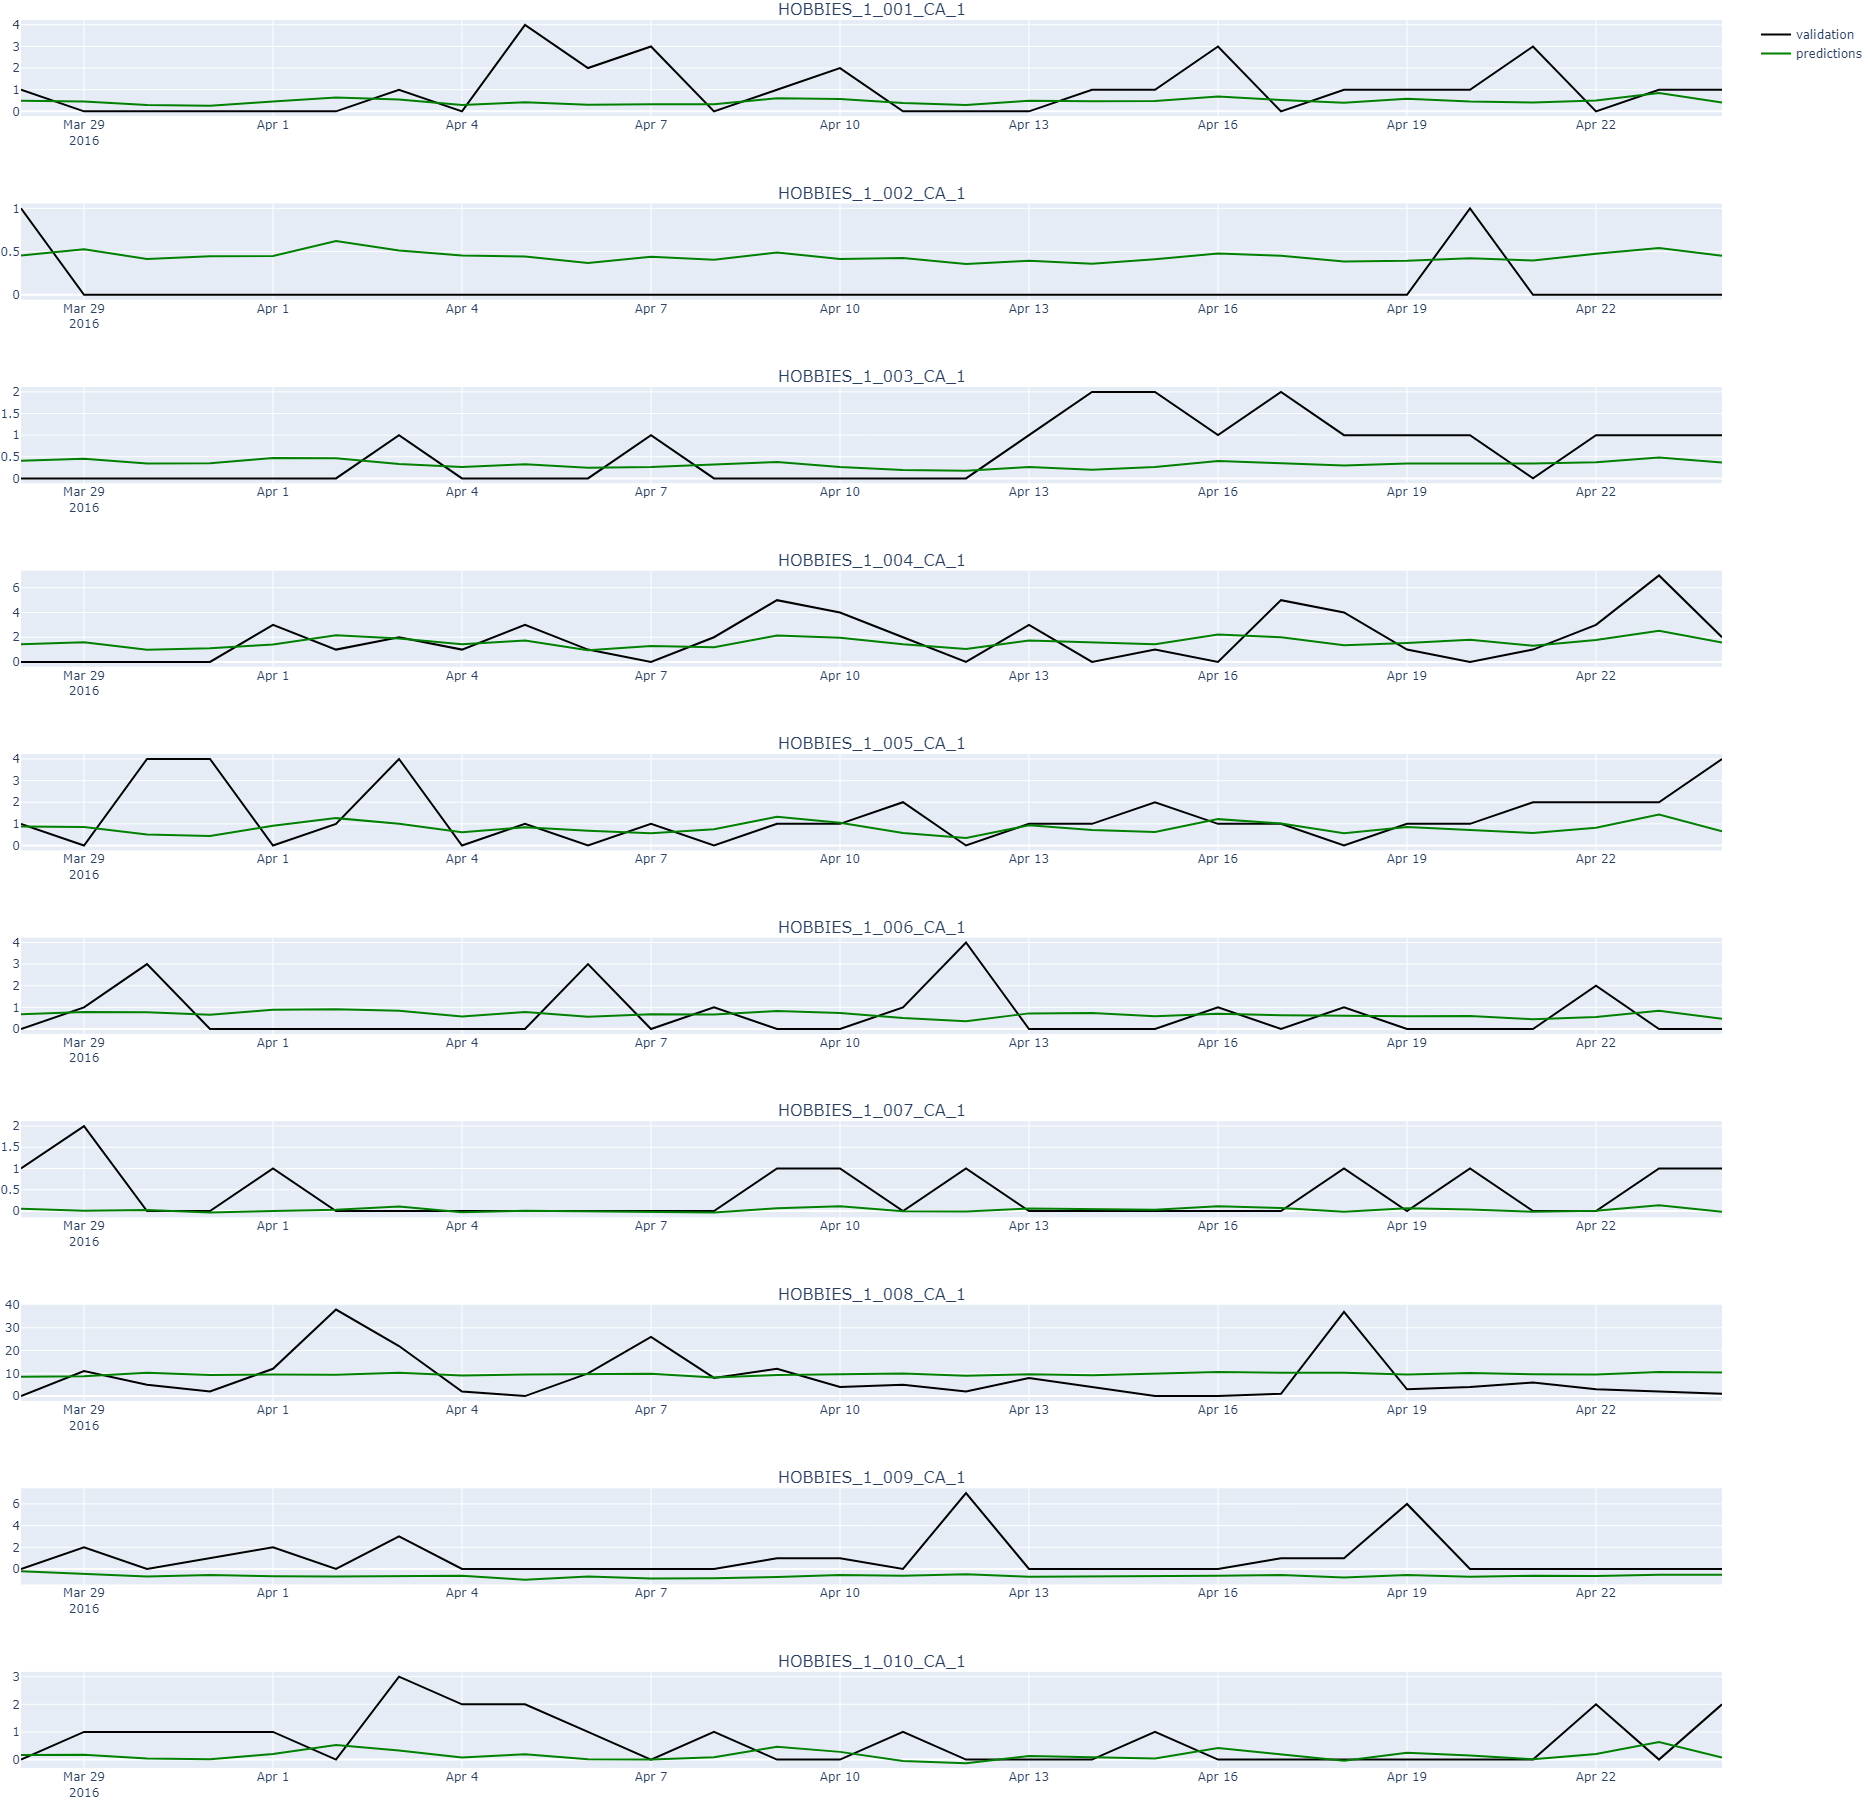

In [32]:
# Visualizing predictions
plot_preds(train_df, valid_df, baseline_model_pred_df, calendar_df)

In [33]:
# Save baseline model
baseline_model.save('../models/baseline_model.keras')